In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/plant-seedlings-classification/"

## Visualize the images. 
Its important to know what dataset we are trainng on

In [3]:
## Lets get the first image from each folder

fnames = os.listdir(f"{PATH}train") #names of the folder

def getFirstImage(directoryName):
    return [glob(f"{PATH}train/{f}/*.png")[0] for f in fnames]


In [4]:
lst_images = getFirstImage(fnames)
lst_images

['data/plant-seedlings-classification/train/Black-grass\\0050f38b3.png',
 'data/plant-seedlings-classification/train/Charlock\\022179d65.png',
 'data/plant-seedlings-classification/train/Cleavers\\005b4a3e3.png',
 'data/plant-seedlings-classification/train/Common Chickweed\\00b6eee9f.png',
 'data/plant-seedlings-classification/train/Common wheat\\012db0f43.png',
 'data/plant-seedlings-classification/train/Fat Hen\\00268e97d.png',
 'data/plant-seedlings-classification/train/Loose Silky-bent\\0012f11c4.png',
 'data/plant-seedlings-classification/train/Maize\\006196e1c.png',
 'data/plant-seedlings-classification/train/Scentless Mayweed\\015215883.png',
 'data/plant-seedlings-classification/train/Shepherds Purse\\006a4d00d.png',
 'data/plant-seedlings-classification/train/Small-flowered Cranesbill\\003402ea0.png',
 'data/plant-seedlings-classification/train/Sugar beet\\0026b7a30.png']

### First image from all the categrory is plotted

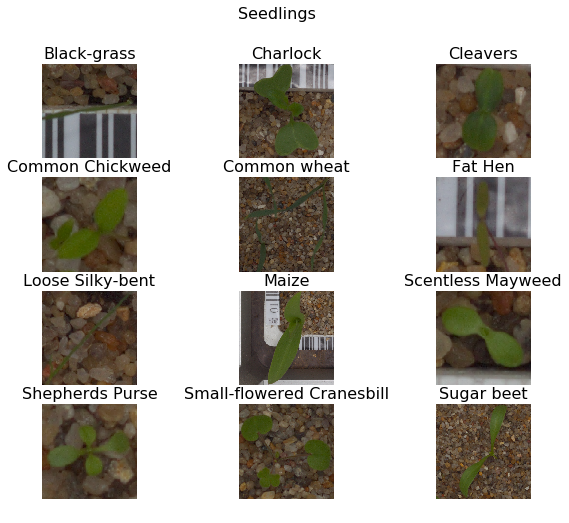

In [5]:
plots_from_files(lst_images, titles=fnames, 
                 maintitle= "Seedlings", figsize=(10,8),
                 rows = 4)

In [ ]:
#Creating a valid directory and placing 20% of the 
#images from each directory inside the valid 

if not os.path.exists(f"{PATH}valid"):
    os.makedirs(f"{PATH}valid")
    shutil.rmtree(f"{PATH}valid")
    for name in fnames:
        os.makedirs(f"{PATH}valid/{name}", exist_ok=True)
else:
    shutil.rmtree(f"{PATH}valid")
    for name in fnames:
        os.makedirs(f"{PATH}valid/{name}", exist_ok=True)
#print the result
os.listdir(f"{PATH}valid")

In [6]:
## #Lets check the #of files for each plant type 
[(f, len(glob(f"{PATH}train/{f}/*")), len(glob(f"{PATH}valid/{f}/*"))) for f in fnames] 

[('Black-grass', 211, 52),
 ('Charlock', 312, 78),
 ('Cleavers', 230, 57),
 ('Common Chickweed', 489, 122),
 ('Common wheat', 177, 44),
 ('Fat Hen', 380, 95),
 ('Loose Silky-bent', 524, 130),
 ('Maize', 177, 44),
 ('Scentless Mayweed', 413, 103),
 ('Shepherds Purse', 185, 46),
 ('Small-flowered Cranesbill', 397, 99),
 ('Sugar beet', 308, 77)]

In [ ]:
# Move 20% of the images from each folder in train to the same name folder in valid directory
for dir in glob(f"{PATH}/train/*"):
    lst_imgs = glob(f"{dir}/*")
    dirName  = dir.split("\\")[1]
    lst_imgs = list(np.random.choice(lst_imgs, int(0.2*len(lst_imgs)), replace=False))
    [shutil.move(f, f"{PATH}valid/{dirName}") for f in lst_imgs]

### Images inside each folder for train and valid

In [ ]:
#Lets check the #of files for each plant type

[(f, len(glob(f"{PATH}train/{f}/*")), len(glob(f"{PATH}valid/{f}/*"))) for f in fnames] 

As you can see the images within `Common Chickwee` and `Loose Silky-bent` are a lot more than that of `Shepherd’s Purse'`. But for the start, I do not focus on _balancing_ the dataset. I try with the dataset, as it is..

In [ ]:
## Check the size of the images by taking a random directory.
dirname = random.sample(fnames, 1)
print ("The directory {} is selected".format(dirname[0]))
## Check the size of the images by taking a random directory, lets say "Charlock"
a = [plt.imread(img).shape for img in glob(f"{PATH}train/{dirname[0]}/*.png")]

In [ ]:
# The histogram of x 
plt.hist([x[0] for x in a])

There are many images whose dimnesions are quite _large_, and they need **resizing**. 

In [ ]:
# The histogram of y
plt.hist([y[1] for y in a])

## 0. Resizing the dataset 

## 1. Train the model

In [7]:
sz= 224
arch=resnet50
bs=64

In [22]:
def get_data(sz, bs):
    tfms  = tfms_from_model(arch, sz, aug_tfms=(transforms_top_down, transforms_side_on), max_zoom=1.1)
    data  = ImageClassifierData.from_paths(PATH, tfms=tfms, 
                                           test_name="test", 
                                           num_workers=8)
    return data 

In [12]:
sz=64
data = get_data(sz, 64)
data = data.resize(int(sz*1.3), 'tmp')

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\gminers/.torch\models\resnet50-19c8e357.pth
100%|███████████████████████████████████████████████████████████████| 102502400/102502400 [00:24<00:00, 4212026.35it/s]


 87%|█████████████████████████████████████████████████████████████▌         | 52/60 [00:03<00:00, 14.72it/s, loss=10.6]


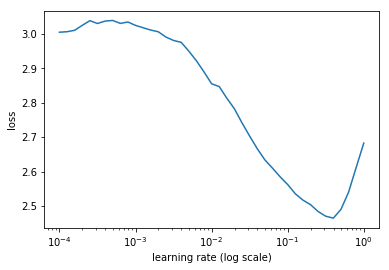

In [14]:
lrf=learn.lr_find()
learn.sched.plot()

In [15]:
lr = 0.1
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.134535   1.401401   0.569166  
    1      1.674675   1.186892   0.602957                                                                              
    2      1.577529   1.208193   0.586061                                                                              
    3      1.386375   1.128385   0.611404                                                                              
    4      1.248198   1.013667   0.645195                                                                              
    5      1.145548   1.004391   0.651531                                                                              
    6      1.214841   1.133872   0.610348                                                                              
    7      1.223595   1.019471   0.654699                                                                           

[array([0.88192]), 0.6927138340385058]

In [16]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.198059   0.792896   0.728617  
    1      0.897612   0.881813   0.68849                                                                               
    2      0.637241   0.421543   0.852165                                                                              
    3      0.624415   0.609234   0.783527                                                                              
    4      0.507064   0.388227   0.862724                                                                              
    5      0.411549   0.305093   0.888068                                                                              
    6      0.340329   0.288656   0.903907                                                                              



[array([0.28866]), 0.9039070752253628]

In [17]:
sz=128

In [18]:
learn.set_data(get_data(sz, 64))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.650724   0.541256   0.810982  
    1      0.592186   0.49277    0.81415                                                                               
    2      0.539151   0.456888   0.848997                                                                              
    3      0.540855   0.523765   0.821542                                                                              
    4      0.512156   0.461039   0.834213                                                                              
    5      0.465461   0.394937   0.860612                                                                              
    6      0.445484   0.392839   0.855333                                                                              



[array([0.39284]), 0.8553326297964441]

In [19]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.44777    0.307482   0.889124  
    1      0.402417   0.277745   0.898627                                                                              
    2      0.292688   0.224679   0.925026                                                                              
    3      0.290775   0.587914   0.796199                                                                              
    4      0.277862   0.198966   0.92925                                                                               
    5      0.216765   0.17455    0.942978                                                                              
    6      0.181372   0.164111   0.947202                                                                              



[array([0.16411]), 0.947201689734756]

In [20]:
sz=256
learn.set_data(get_data(sz, 64))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.331226   0.27545    0.912355  
    1      0.30714    0.252112   0.922914                                                                              
    2      0.28912    0.233538   0.926082                                                                              
    3      0.318097   0.245331   0.921859                                                                              
    4      0.299803   0.230425   0.920803                                                                              
    5      0.259536   0.213318   0.928194                                                                              
    6      0.240161   0.211997   0.933474                                                                              



[array([0.212]), 0.9334741290796394]

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.320582   0.222977   0.930306  
    1      0.322192   0.748449   0.75396                                                                               
    2      0.233212   0.161284   0.947202                                                                              
    3      0.245254   0.301699   0.898627                                                                              
 18%|████████████▊                                                         | 11/60 [00:11<00:51,  1.05s/it, loss=0.244]

In [ ]:
?get_cv_idxs

In [ ]:
get_cv_idxs(200)

In [ ]:
pwd

In [ ]:
PATH

In [ ]:
glob(f"{PATH}*")

In [ ]:
if not os.path

In [ ]:
if not os.path.exists(f"{PATH}valid"):
    os.makedirs(f"{PATH}valid")